In [ ]:
!python NnSim.py

In [3]:
# train the emulator using DBN chains as the training data
# run FBNN to get 2000 posterior samples

import numpy as np
import os,argparse,pickle,sys
np.random.seed(2023)

# modules
import os,argparse,pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# the inverse problem
from NnSim import NnSim

# MCMC
import sys
sys.path.append( "../" )
from nn.dnn import DNN
#from nn.cnn import CNN
from nn.ae import AutoEncoder
#from nn.cae import ConvAutoEncoder
#from nn.vae import VAE
from sampler.FBNN import FBNN

# relevant geometry
import geom_emul
from geom_latent import *

# set to warn only once for the same warnings
tf.get_logger().setLevel('ERROR')
np.set_printoptions(precision=3, suppress=True)
np.random.seed(2023)
tf.random.set_seed(2023)


parser = argparse.ArgumentParser()
parser.add_argument('algNO', nargs='?', type=int, default=0)
parser.add_argument('emuNO', nargs='?', type=int, default=0)
parser.add_argument('aeNO', nargs='?', type=int, default=0)
parser.add_argument('num_samp', nargs='?', type=int, default=2000)
parser.add_argument('num_burnin', nargs='?', type=int, default=20)
parser.add_argument('step_sizes', nargs='?', type=float, default=[.01,.005,.005,None,None]) # AE [.01,.005,.01]
parser.add_argument('step_nums', nargs='?', type=int, default=[1,1,5,1,5])
parser.add_argument('algs', nargs='?', type=str, default=['FBNN'+a for a in ('pCN','infMALA','infHMC','infmMALA','infmHMC')])
parser.add_argument('emus', nargs='?', type=str, default=['dnn','cnn'])
parser.add_argument('aes', nargs='?', type=str, default=['ae','cae','vae'])
args = parser.parse_args(args=[])

# set up
folder = './result'
d=3; m=1000
with open(os.path.join(folder, 'nn.pickle'), 'rb') as f:
  [pr_cov,X,y] = pickle.load(f)
print('Data loaded!\n')
kwargs={'X':X,'y':y}

nnsim=NnSim(d,m,pr_cov=pr_cov,**kwargs)

y=nnsim.y
print(nnsim.X.shape, nnsim.y.shape)
nnsim.prior={'mean':np.zeros(56),'cov':np.eye(56),'sample':nnsim.sample}

##---- CALIBRATION ----##
# load the data from BNN posterior samples
sys.path.append( "../" )
folder = './analysis'
# BNN calibration
with open(os.path.join(folder, 'calibration_bnn.pickle'), 'rb') as f:
  [init_weights, state_dicts, yhats, ps] = pickle.load(f)
def state_dict_to_array(state_dict):
  return np.concatenate([np.array(state_dict.get(key)).flatten(order='F') for key in [
    'block.0.weight','block.2.weight', 'block.4.weight','block.0.bias','block.2.bias', 'block.4.bias']])
train_emul_data = np.array([state_dict_to_array(state_dicts[i]) for i in range(2000)])
print(ps.shape)
print(train_emul_data.shape)

##---- EMULATOR ----##
# training data for DNN emulator
X = train_emul_data[0:200]; Y = ps[0:200]
num_samp=X.shape[0]
tr_idx=np.random.choice(num_samp,size=np.floor(.75*num_samp).astype('int'),replace=False)
te_idx=np.setdiff1d(np.arange(num_samp),tr_idx)
x_train,x_test=X[tr_idx],X[te_idx]
y_train,y_test=Y[tr_idx],Y[te_idx]
# define emulator
depth=3
node_sizes=np.array([x_train.shape[1], 256, 512, y_train.shape[1]])

activations={'hidden':'relu','output':'sigmoid'}
droprate=0
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
emulator=DNN(x_train.shape[1], y_train.shape[1], depth=depth, droprate=droprate,
              activations=activations, optimizer=optimizer, node_sizes=node_sizes)
# load or train emulator
folder = './train_NN'
try:
  emulator.model=load_model(os.path.join(folder, 'dnn.h5'),custom_objects={'loss':None})
  print('DNN has been loaded!')
except:
  epochs=200
  patience=10
  emulator.train(
      x_train,y_train,x_test=x_test,y_test=y_test,
      epochs=epochs,batch_size=64,verbose=1,patience=patience)
  # save
  emulator.model.save(os.path.join(folder,'dnn.h5'))


##---- AUTOENCODER ----##
# did not use ae in this setting
if 0:
  # prepare for training data
  num_samp=X.shape[0]
  tr_idx=np.random.choice(num_samp,size=np.floor(.75*num_samp).astype('int'),replace=False)
  te_idx=np.setdiff1d(np.arange(num_samp),tr_idx)
  x_train,x_test=X[tr_idx],X[te_idx]
  # define autoencoder
  half_depth=3; latent_dim=10
  droprate=0.
  activation=tf.keras.layers.LeakyReLU(alpha=2.)
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,amsgrad=True)
  lambda_=0.
  autoencoder=AutoEncoder(x_train.shape[1], half_depth=half_depth, latent_dim=latent_dim, droprate=droprate,
                          activation=activation, optimizer=optimizer)

  f_name=['fullmodel','encoder','decoder']

  # load or train autoencoder
  try:
      autoencoder.model=load_model(os.path.join(folder,f_name[0]+'.h5'),custom_objects={'loss':None})
      print(f_name[0]+' has been loaded!')
      autoencoder.encoder=load_model(os.path.join(folder,f_name[1]+'.h5'),custom_objects={'loss':None})
      print(f_name[1]+' has been loaded!')
      autoencoder.decoder=load_model(os.path.join(folder,f_name[2]+'.h5'),custom_objects={'loss':None})
      print(f_name[2]+' has been loaded!')
  except:
      epochs=500
      patience=10
      noise=0.
      kwargs={'patience':patience}
      if noise: kwargs['noise']=noise
      autoencoder.train(x_train,x_test=x_test,epochs=epochs,batch_size=64,verbose=1,**kwargs)
      # save autoencoder
      autoencoder.model.save(os.path.join(folder,f_name[0]+'.h5'))
      autoencoder.encoder.save(os.path.join(folder,f_name[1]+'.h5'))
      autoencoder.decoder.save(os.path.join(folder,f_name[2]+'.h5'))


  # set up latent
  class NnSim_lat:
      def __init__(self,input_dim):
          self.input_dim=input_dim
      def sample(self,num_samp=1):
          samp=np.random.randn(num_samp,self.input_dim)
          return np.squeeze(samp)
  nnsim_latent=NnSim_lat(latent_dim)
  nnsim_latent.prior={'mean':np.zeros(nnsim_latent.input_dim),'cov':np.eye(nnsim_latent.input_dim), 'sample':nnsim_latent.sample}

##end of ---- AUTOENCODER ----##

##------ define MCMC ------##

emul_geom=lambda q,geom_ord=[0],whitened=False,**kwargs:geom_emul.geom(q,nnsim,emulator,geom_ord,whitened,**kwargs)

init_samp = train_emul_data[1000,:]

fbnn=FBNN(init_samp, nnsim, emul_geom,.01,1,'FBNNpCN',whitened=False,vol_wts='adjust',AE=None)

mc_fun=fbnn.sample
mc_args=(args.num_samp,args.num_burnin)
mc_fun(*mc_args)

Data loaded!

(1000, 3) (1000,)


(2000, 1000)
(2000, 56)
DNN has been loaded!

Running DREAMpCN now...


Burn-in completed; recording samples now...


Acceptance at 100 iterations: 1.00

Acceptance at 200 iterations: 1.00

Acceptance at 300 iterations: 1.00

Acceptance at 400 iterations: 1.00

Acceptance at 500 iterations: 1.00

Acceptance at 600 iterations: 1.00

Acceptance at 700 iterations: 1.00

Acceptance at 800 iterations: 1.00

Acceptance at 900 iterations: 1.00

Acceptance at 1000 iterations: 1.00

Acceptance at 1100 iterations: 1.00

Acceptance at 1200 iterations: 1.00

Acceptance at 1300 iterations: 1.00

Acceptance at 1400 iterations: 1.00

Acceptance at 1500 iterations: 1.00

Acceptance at 1600 iterations: 1.00

Acceptance at 1700 iterations: 1.00

Acceptance at 1800 iterations: 1.00

Acceptance at 1900 iterations: 1.00

Acceptance at 2000 iterations: 1.00

After 2.54238 seconds, 2000 samples have been collected with the final acceptance rate 1.00 



In [4]:
# MCMC plot and accuracy
import numpy as np
from tensorflow.keras.models import load_model
import os,argparse,pickle
import matplotlib.pyplot as plt

folder_path = r"./result"
files = os.listdir("./result")
latest_file = [f for f in files if f[-5:]==".pckl"][-1]
print(latest_file)


#FBNN
with open('./result/FBNNpCN_dim56_2023-10-05-15-07-44.pckl','rb') as f:
    [h, L, alg_name, samp, loglik, logwts, acpt, time, times]=pickle.load(f)


posterior_samp = samp

if 0:
  figure, axis = plt.subplots(7, 8)
  for i in range(56):
    axis[i//8, i%8].plot(range(args.num_samp), posterior_samp[:,i])
  plt.show()


# prediction vs. real y values
def accuracy_check(nnsim_name):
  pos_step = 100
  overall_accuracy = 0.0
  for start in range(0, args.num_samp, pos_step):
    end = start + pos_step
    accuracy = 0.0
    for i in range(start, end):
      p_hats_bnn = nnsim_name.forward(posterior_samp[i, :])
      y_hats_bnn = (p_hats_bnn>0.5).astype(float)
      accuracy += np.mean(nnsim_name.y == y_hats_bnn)
    accuracy = accuracy / (end - start)
    print(start, '-', end, ' accuracy:',  np.round(accuracy, 2))
    overall_accuracy += accuracy
  overall_accuracy = overall_accuracy / (args.num_samp / pos_step)
  print("overall accuracy:", np.round(overall_accuracy, 2))
  return(p_hats_bnn.shape)

# training accuracy
folder = './result'
d=3; m=1000
with open(os.path.join(folder, 'nn.pickle'), 'rb') as f:
  [pr_cov,X,y] = pickle.load(f)
kwargs={'X':X,'y':y}

nnsim=NnSim(d,m,pr_cov=pr_cov,**kwargs)

print("training accuracy")
accuracy_check(nnsim)


# # test accuracy
folder = './result/test'
d=3; m=1000
with open(os.path.join(folder, 'nn.pickle'), 'rb') as f:
  [pr_cov,X,y] = pickle.load(f)
kwargs={'X':X,'y':y}

nnsim=NnSim(d,m,pr_cov=pr_cov,**kwargs)

print("test accuracy")
accuracy_check(nnsim)

DREAMpCN_dim56_2023-10-05-15-07-44.pckl
training accuracy
0 - 100  accuracy: 0.98
100 - 200  accuracy: 0.97
200 - 300  accuracy: 0.97
300 - 400  accuracy: 0.97
400 - 500  accuracy: 0.97
500 - 600  accuracy: 0.97
600 - 700  accuracy: 0.97
700 - 800  accuracy: 0.97
800 - 900  accuracy: 0.97
900 - 1000  accuracy: 0.97
1000 - 1100  accuracy: 0.97
1100 - 1200  accuracy: 0.97
1200 - 1300  accuracy: 0.97
1300 - 1400  accuracy: 0.97
1400 - 1500  accuracy: 0.97
1500 - 1600  accuracy: 0.97
1600 - 1700  accuracy: 0.97
1700 - 1800  accuracy: 0.97
1800 - 1900  accuracy: 0.97
1900 - 2000  accuracy: 0.96
overall accuracy: 0.97
test accuracy
0 - 100  accuracy: 0.97
100 - 200  accuracy: 0.96
200 - 300  accuracy: 0.96
300 - 400  accuracy: 0.95
400 - 500  accuracy: 0.95
500 - 600  accuracy: 0.96
600 - 700  accuracy: 0.96
700 - 800  accuracy: 0.96
800 - 900  accuracy: 0.96
900 - 1000  accuracy: 0.96
1000 - 1100  accuracy: 0.96
1100 - 1200  accuracy: 0.96
1200 - 1300  accuracy: 0.96
1300 - 1400  accuracy: 

(1000,)

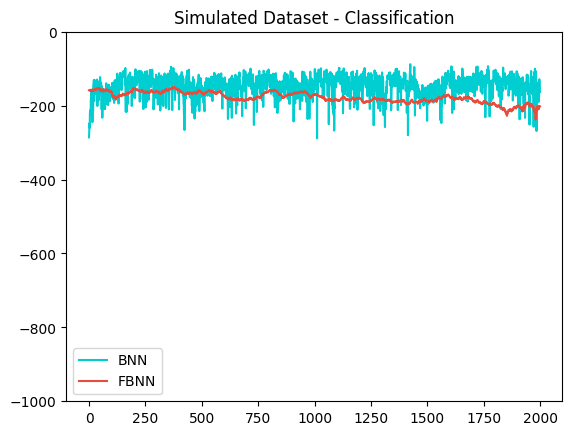

In [5]:
import matplotlib.pyplot as plt
import numpy as np

num_iter = 2000
num_epochs = 2000

# Define alternative colors for your plots
bnn_color = 'darkturquoise'  # A shade of blue
fbnn_color = '#e74c3c'  # A shade of red

plt.plot(range(num_epochs),
         np.array([nnsim.logpdf(train_emul_data[i, :]) for i in range(num_epochs)]).flatten(),
         label="BNN", color=bnn_color)

plt.plot(range(2000),
         np.array([nnsim.logpdf(posterior_samp[i, :]) for i in range(2000)]).flatten(),
         label="FBNN", color=fbnn_color)

plt.title("Simulated Dataset - Classification")
plt.ylim(-1000, 0)
plt.legend()
plt.show()

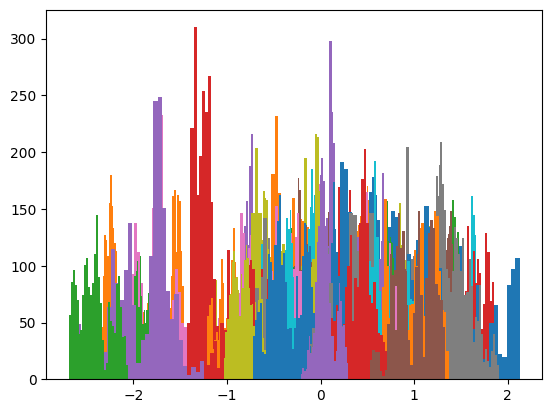

In [9]:
# posterior sample distribution
start, end = 0, args.num_samp
for i in range(posterior_samp.shape[1]):
  plt.hist(posterior_samp[start:end, i], bins = 30)
plt.show()

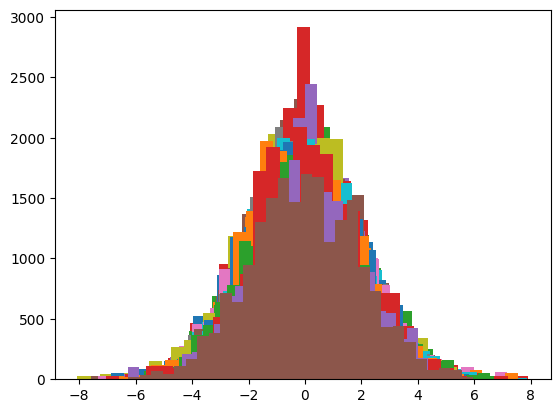

In [ ]:
# training data for emulator ("calibration" result) distribution
for i in range(train_emul_data.shape[1]):
  plt.hist(train_emul_data[:, i], bins = 30)
plt.show()

In [6]:
import numpy as np
import arviz as az

# Initialize an array to store the ESS values for all parameters
ess_values = np.zeros(56)

# Initialize lists to store ESS values for each parameter
ess_per_parameter = []

# Iterate over each parameter (column) in the posterior samples
for param_idx in range(56):
    # Extract the samples for the current parameter

    #bnn
    param_samples = train_emul_data[:, param_idx]

    # Calculate IACT using arviz for the current parameter
    iact = az.ess(param_samples)

    # Compute the effective sample size (ESS) for the current parameter
    ess = len(param_samples) / iact

    # Store the ESS value for the current parameter in the list
    ess_per_parameter.append(ess)

    # Store the ESS value for the current parameter in the array
    ess_values[param_idx] = ess

# Calculate the total effective sample size (ESS) by summing all ESS values
total_ess = np.sum(ess_values)

# Calculate the minimum, maximum, and median ESS values
min_ess = np.min(ess_per_parameter)
max_ess = np.max(ess_per_parameter)
median_ess = np.median(ess_per_parameter)

min_ess, median_ess, max_ess, min_ess/889

(23.024401706338992,
 189.55128519937887,
 1468.6854886637116,
 0.025899214517816637)

In [7]:
import numpy as np
import arviz as az

# Initialize an array to store the ESS values for all parameters
ess_values = np.zeros(56)

# Initialize lists to store ESS values for each parameter
ess_per_parameter = []

# Iterate over each parameter (column) in the posterior samples
for param_idx in range(56):
    # Extract the samples for the current parameter

    #bnn
    param_samples = posterior_samp[:, param_idx]

    # Calculate IACT using arviz for the current parameter
    iact = az.ess(param_samples)

    # Compute the effective sample size (ESS) for the current parameter
    ess = len(param_samples) / iact

    # Store the ESS value for the current parameter in the list
    ess_per_parameter.append(ess)

    # Store the ESS value for the current parameter in the array
    ess_values[param_idx] = ess

# Calculate the total effective sample size (ESS) by summing all ESS values
total_ess = np.sum(ess_values)

# Calculate the minimum, maximum, and median ESS values
min_ess = np.min(ess_per_parameter)
max_ess = np.max(ess_per_parameter)
median_ess = np.median(ess_per_parameter)

min_ess, median_ess, max_ess, min_ess/92

(153.116344110661, 871.7014055279944, 1520.7568981917093, 1.6643080881593588)